In [1]:
pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.applications import ResNet50
#from efficientnet.tfkeras import EfficientNetB3
from keras.applications import InceptionV3
from keras.applications import MobileNetV2
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report



2024-06-20 13:37:59.793308: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 13:37:59.793427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 13:37:59.926308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


IMPORT DATA

In [3]:
dataTrain = '/kaggle/input/datasetbatik/Batik276-Splitted/train'
dataVal = '/kaggle/input/datasetbatik/Batik276-Splitted/val'

In [4]:
import imghdr

def count_images_and_formats(directory):
    formats = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_extension = os.path.splitext(file)[1].lower()
            if file_extension in formats:
                formats[file_extension] += 1
            else:
                formats[file_extension] = 1
    total_images = sum(formats.values())
    return total_images, formats

# Count the number of images and their formats
train_image_count, train_formats = count_images_and_formats(dataTrain)
val_image_count, val_formats = count_images_and_formats(dataVal)

# Display the total number of images and their formats
print("Total number of training images: ", train_image_count)
print("Training image formats: ", train_formats)
print("Total number of testing images: ", val_image_count)
print("Testing image formats: ", val_formats)

Total number of training images:  588
Training image formats:  {'.jpg': 588}
Total number of testing images:  195
Testing image formats:  {'.jpg': 195}


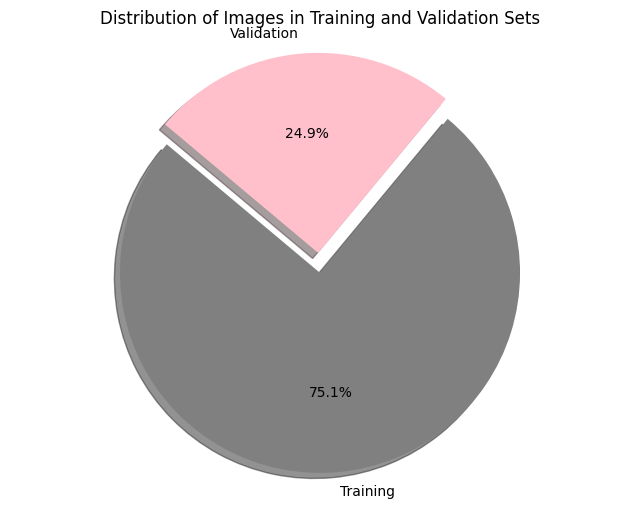

In [5]:
import matplotlib.pyplot as plt

# Total number of images in training and validation sets
total_train_images = train_image_count
total_val_images = val_image_count

# Calculate percentages
train_percent = (total_train_images / (total_train_images + total_val_images)) * 100
val_percent = (total_val_images / (total_train_images + total_val_images)) * 100

# Plotting
labels = ['Training', 'Validation']
sizes = [train_percent, val_percent]
colors = ['grey', 'pink']
explode = (0.1, 0)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Images in Training and Validation Sets')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [6]:
def count_images_in_each_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([file for file in os.listdir(class_path) if file.endswith(('.jpg', '.jpeg', '.png'))])
    return class_counts

# Directory to be analyzed
directory = dataVal

# Count the number of images in each class
class_counts = count_images_in_each_class(directory)

# Display the number of images in each class
print('List Of All Class :')
for class_name, count in class_counts.items():
    print('===================')
    print(f"'{class_name}': {count}")

List Of All Class :
'batik-cendrawasih': 10
'batik-gentongan': 10
'batik-sidomukti': 9
'batik-sidoluhur': 10
'batik-pekalongan': 10
'batik-celup': 10
'batik-keraton': 10
'batik-lasem': 10
'batik-sogan': 10
'batik-sekar': 9
'batik-kawung': 9
'batik-parang': 10
'batik-priangan': 10
'batik-ceplok': 9
'batik-garutan': 10
'batik-betawi': 10
'batik-ciamis': 10
'batik-megamendung': 9
'batik-tambal': 10
'batik-bali': 10


In [7]:
def count_images_in_each_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([file for file in os.listdir(class_path) if file.endswith(('.jpg', '.jpeg', '.png'))])
    return class_counts

# Directory to be analyzed
directory = dataTrain

# Count the number of images in each class
class_counts = count_images_in_each_class(directory)

# Display the number of images in each class
print('List Of All Class :')
for class_name, count in class_counts.items():
    print('===================')
    print(f"'{class_name}': {count}")

List Of All Class :
'batik-cendrawasih': 30
'batik-gentongan': 30
'batik-sidomukti': 27
'batik-sidoluhur': 30
'batik-pekalongan': 30
'batik-celup': 30
'batik-keraton': 30
'batik-lasem': 30
'batik-sogan': 30
'batik-sekar': 28
'batik-kawung': 27
'batik-parang': 30
'batik-priangan': 30
'batik-ceplok': 28
'batik-garutan': 30
'batik-betawi': 30
'batik-ciamis': 30
'batik-megamendung': 28
'batik-tambal': 30
'batik-bali': 30


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import UnidentifiedImageError
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def custom_load_img(path, grayscale=False, color_mode='rgb', target_size=None, interpolation='nearest'):
    try:
        return load_img(path, color_mode=color_mode, target_size=target_size, interpolation=interpolation)
    except UnidentifiedImageError:
        print(f"Cannot identify image file {path}")
        return None

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=0.30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=False,
                                   vertical_flip=False,
                                   fill_mode='nearest',
                                   preprocessing_function=custom_load_img,
                                  )

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

#Train
train_gen = train_datagen.flow_from_directory(dataTrain,
                                              target_size=(300, 300),
                                              shuffle=True,
                                              color_mode='rgb',
                                              class_mode='categorical'
                                             )

#Validation
val_gen = val_datagen.flow_from_directory(dataVal,
                                          target_size=(300,300),
                                          batch_size=32,
                                          shuffle=True,
                                          color_mode='rgb',
                                          class_mode='categorical'
                                         )
#Test
test_gen = test_datagen.flow_from_directory(dataVal,
                                            target_size=(300,300),
                                            batch_size=32,
                                            shuffle=True,
                                            color_mode='rgb',
                                            class_mode='categorical'
                                           )

Found 588 images belonging to 20 classes.
Found 195 images belonging to 20 classes.
Found 195 images belonging to 20 classes.


In [9]:
from tensorflow.keras.applications import EfficientNetB3

base_model = EfficientNetB3(input_shape=(300, 300, 3),
                            include_top=False,
                            weights="imagenet",
                            pooling='avg',
                           )


base_model.trainable=False

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model= tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(20, activation='softmax')
])

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
            train_gen,
            validation_data = val_gen,
            epochs = 50,
            verbose = 1,)

TypeError: path should be path-like or io.BytesIO, not <class 'numpy.ndarray'>